# Imports

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io

from tensorflow.keras.preprocessing.sequence import pad_sequences

# Get the dataset

In [2]:
!wget --no-check-certificate \
    https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P \
    -O /tmp/sentiment.csv

--2021-04-03 20:09:52--  https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P
Resolving drive.google.com (drive.google.com)... 74.125.142.101, 74.125.142.113, 74.125.142.138, ...
Connecting to drive.google.com (drive.google.com)|74.125.142.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-08-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/nrh2jjmjcbl786lo77ho0d8qgkto2m9p/1617480525000/11118900490791463723/*/13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P [following]
--2021-04-03 20:09:53--  https://doc-08-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/nrh2jjmjcbl786lo77ho0d8qgkto2m9p/1617480525000/11118900490791463723/*/13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P
Resolving doc-08-ak-docs.googleusercontent.com (doc-08-ak-docs.googleusercontent.com)... 74.125.142.132, 2607:f8b0:400e:c08::84
Connecting to doc-08-ak-docs.googleusercontent.com (doc-08-ak-docs.googleusercontent.com)|74.125

In [3]:
dataset = pd.read_csv('/tmp/sentiment.csv')

sentences = dataset['text'].tolist()
labels = dataset['sentiment'].tolist()

# Create a subword dataset

In [4]:
vocab_size = 1000
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(sentences,
                                                                      vocab_size, 
                                                                      max_subword_length=5)
num = 5
print(sentences[num])
encoded = tokenizer.encode(sentences[num])
print(encoded)

I have to jiggle the plug to get it to line up right to get decent volume.
[4, 31, 6, 849, 162, 450, 12, 1, 600, 438, 775, 6, 175, 14, 6, 55, 213, 159, 474, 775, 6, 175, 614, 380, 295, 148, 72, 789]


In [5]:
# Separately print out each subword
for i in encoded:
  print(tokenizer.decode([i]))

I 
have 
to 
j
ig
gl
e 
the 
pl
ug
 
to 
get 
it 
to 
li
ne 
up 
right
 
to 
get 
dec
ent 
vo
lu
me
.


# Replace sentence data with encoded subwords

In [6]:
for i, sentence in enumerate(sentences):
  sentences[i] = tokenizer.encode(sentence)

In [7]:
print(sentences[1])

[625, 677, 626, 274, 380, 633, 148, 844, 789]


# Some pre-processing

In [8]:
max_length = 50
trunc_type='post'
padding_type='post'

sentences_padded = pad_sequences(sentences, maxlen=max_length, 
                                 padding=padding_type, truncating=trunc_type)

# Separate out the sentences and labels into training and test sets
training_size = int(len(sentences) * 0.8)

training_sentences = sentences_padded[0:training_size]
testing_sentences = sentences_padded[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

# Make labels into numpy arrays for use with the network later
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

# Train the model

In [9]:
embedding_dim = 16
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            16000     
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 102       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 16,109
Trainable params: 16,109
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Compile the model
num_epochs = 20

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Fit the model
history = model.fit(training_sentences,
                    training_labels_final,
                    epochs=num_epochs,
                    validation_data=(testing_sentences,testing_labels_final))

Epoch 1/20
50/50 [==============================] - 4s 12ms/step - loss: 0.6928 - accuracy: 0.4990 - val_loss: 0.6975 - val_accuracy: 0.4110
Epoch 2/20
50/50 [==============================] - 0s 4ms/step - loss: 0.6887 - accuracy: 0.5224 - val_loss: 0.6934 - val_accuracy: 0.4912
Epoch 3/20
50/50 [==============================] - 0s 4ms/step - loss: 0.6790 - accuracy: 0.5796 - val_loss: 0.6844 - val_accuracy: 0.5664
Epoch 4/20
50/50 [==============================] - 0s 4ms/step - loss: 0.6678 - accuracy: 0.6487 - val_loss: 0.6802 - val_accuracy: 0.5288
Epoch 5/20
50/50 [==============================] - 0s 4ms/step - loss: 0.6479 - accuracy: 0.6767 - val_loss: 0.6611 - val_accuracy: 0.5915
Epoch 6/20
50/50 [==============================] - 0s 4ms/step - loss: 0.6129 - accuracy: 0.7459 - val_loss: 0.6406 - val_accuracy: 0.6341
Epoch 7/20
50/50 [==============================] - 0s 4ms/step - loss: 0.5833 - accuracy: 0.7683 - val_loss: 0.6143 - val_accuracy: 0.6917
Epoch 8/20
50/50 [=

In [11]:
def plot_graphs(history,string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel('Epochs')
  plt.ylabel(string)
  plt.legend([string,'val_'+string])
  plt.show()

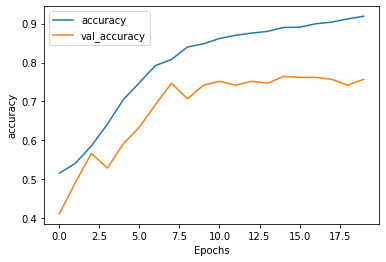

In [12]:
plot_graphs(history,'accuracy')

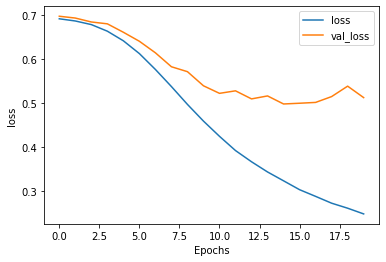

In [13]:
plot_graphs(history,'loss')

# Get files to visualize

In [14]:
# First get the weights of the embedding layer
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

(1000, 16)


In [14]:
# Write out the embedding vectors and metadata
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(0, vocab_size - 1):
  word = tokenizer.decode([word_num])
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

# Dowload files to go to `project tensorflow` to visualize them

In [ ]:
# Download the files
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')